In [1]:
import sys
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import h5py
from scipy import sparse
# import tables
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from pathlib import Path
from numpy import linalg as LA
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
def max_norm_matrix(dense):

    dense[np.isinf(dense)]= 0.0
    dense[np.isnan(dense)]= 0.0

    print("Maximum value: ", dense.max())

    np.fill_diagonal(dense,0.0)
    dense=np.triu(dense, k=-np.shape(dense)[0])

    dense = normalize(dense, axis=0, norm='max')
    # dense=dense+np.transpose(dense)

    np.fill_diagonal(dense,1.0)
    return dense

Maximum value:  119031.13
Dense matrix shape:  (1356, 1356)


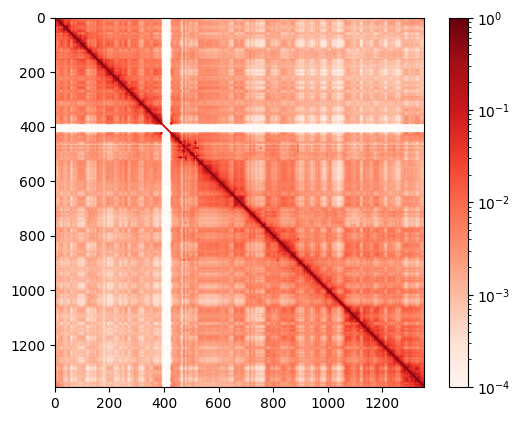

In [20]:
file_hic = 'input/chr10_100k.dense'

hic = np.loadtxt(file_hic)

hic_norm = max_norm_matrix(hic)

print("Dense matrix shape: ", hic_norm.shape)

plt.imshow(hic_norm,norm=mpl.colors.LogNorm(vmin = 0.0001, vmax=hic_norm.max()),cmap='Reds')
plt.colorbar()

file_name = 'chr10_100k.dense'

plt.savefig(file_name + '.pdf', bbox_inches='tight')

Maximum value:  119031.13
Dense matrix shape:  (1356, 1356)


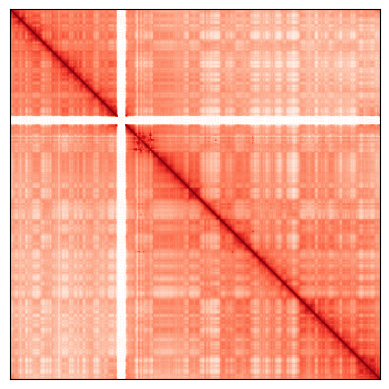

In [9]:
file_hic = 'input/chr10_100k.dense'

hic = np.loadtxt(file_hic)

hic_norm = max_norm_matrix(hic)

hic_norm[393:424,:] = .0
hic_norm[:,393:424] = .0

print("Dense matrix shape: ", hic_norm.shape)

plt.imshow(hic_norm,norm=mpl.colors.LogNorm(vmin = 0.0001, vmax=hic_norm.max()),cmap='Reds')
# plt.axis('off')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.savefig(file_hic + '.pdf', bbox_inches='tight', dpi=600)

In [10]:
# find the index where the first neighbor is equal to zero
diag1 = np.diag(hic_norm, k=1)
diag2 = np.diag(hic_norm, k=2)

NA_index = np.union1d(np.where(diag1 == 0.0)[0], np.where(diag2 <= 0.001)[0])
NA_index.shape, NA_index

((48,),
 array([390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
        403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
        416, 417, 418, 419, 420, 421, 422, 423, 462, 463, 464, 465, 466,
        467, 468, 476, 477, 478, 480, 481, 482, 490]))

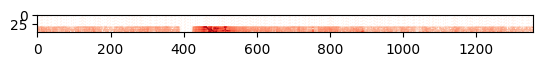

In [11]:
plt.imshow(hic_norm[NA_index],norm=mpl.colors.LogNorm(vmin = 0.0001, vmax=hic_norm.max()),cmap='Reds')

Filling the NAs with average of the whole/2 neigbors

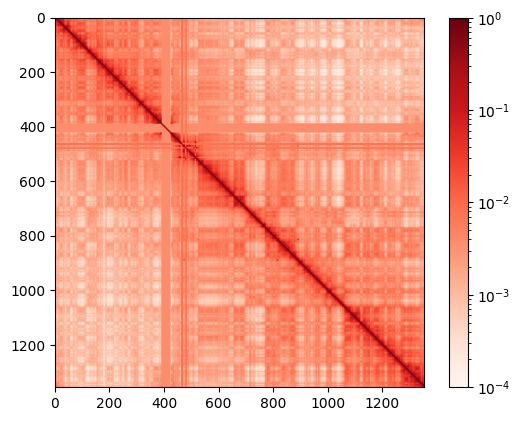

In [12]:
hic_filled = np.copy(hic_norm)

hic_filled[390:423,:] = np.average(hic_norm[390-12:423+12,])
hic_filled[:,390:423] = np.average(hic_norm[390-12:423+12,])

hic_filled[462:469,:] = np.average(hic_norm[462-12:469+12,])
hic_filled[:,462:469] = np.average(hic_norm[462-12:469+12,])

hic_filled[476:479,:] = np.average(hic_norm[476-12:479+12,])
hic_filled[:,476:479] = np.average(hic_norm[476-12:479+12,])

hic_filled[480:483,:] = np.average(hic_norm[480-12:483+12,])
hic_filled[:,480:483] = np.average(hic_norm[480-12:483+12,])

hic_filled[490:491,:] = np.average(hic_norm[490-12:491+12,])
hic_filled[:,490:491] = np.average(hic_norm[490-12:491+12,])

np.fill_diagonal(hic_filled,1.0)

plt.imshow(hic_filled,norm=mpl.colors.LogNorm(vmin = 0.0001, vmax=hic_norm.max()),cmap='Reds')
plt.colorbar()

# save new file dense and plot
file_hic_filled_NA = 'chr10_100k_NA_average.dense'
np.savetxt(file_hic_filled_NA, hic_filled)

plt.savefig(file_hic_filled_NA + '.pdf', bbox_inches='tight')


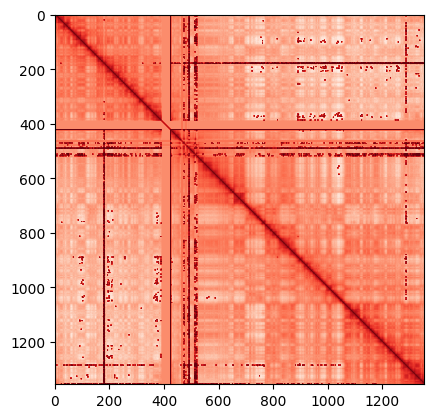

In [13]:
# testing where it's blank
hic_filled2 = np.copy(hic_filled)
index = np.where(hic_filled == 0)
hic_filled2[index] = 5
# print(hic_filled2.shape, hic_filled2)

plt.imshow(hic_filled2,norm=mpl.colors.LogNorm(vmin = 0.0001, vmax=hic_norm.max()),cmap='Reds')

Filling the NAs with the gradient scale of the genome distance

In [14]:
NA_index.shape, NA_index

((48,),
 array([390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
        403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
        416, 417, 418, 419, 420, 421, 422, 423, 462, 463, 464, 465, 466,
        467, 468, 476, 477, 478, 480, 481, 482, 490]))

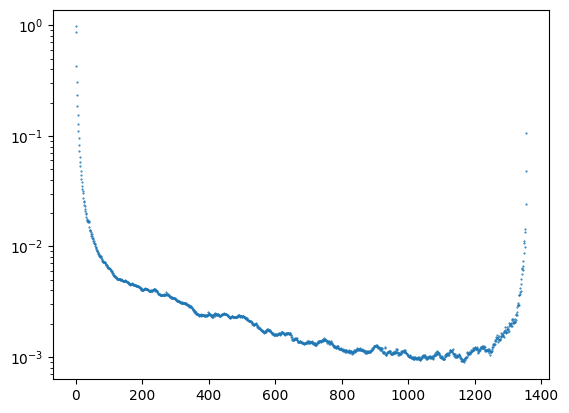

In [15]:
# Diagonal values
# %%timeit
hic_filled = np.copy(hic_norm)

diagonal_strength = np.array([])
for i in range(0,np.shape(hic_filled)[0]):
    diagonal_strength = np.append(diagonal_strength, (np.mean(np.diagonal(hic_filled,offset=i))))

plt.plot(diagonal_strength, '.', markersize=1)
plt.yscale('log')

Maximum value:  1.0


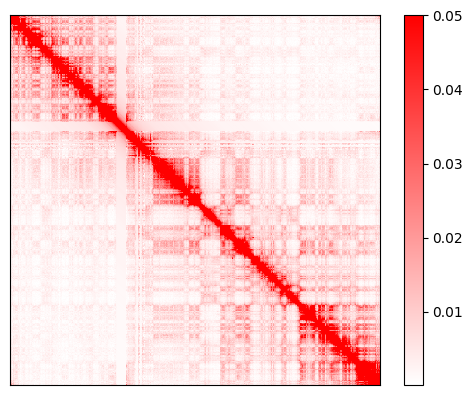

In [16]:
for NA in NA_index:
    if NA == 0:
        hic_filled[0,:] = diagonal_strength
    else:
        hic_filled[NA,NA:] = diagonal_strength[0:-NA]
        hic_filled[:NA,NA] = diagonal_strength[0:NA][::-1]
        
hic_filled_norm = max_norm_matrix(hic_filled)
hic_filled_norm = np.triu(hic_filled_norm,k=-np.shape(hic_filled_norm)[0])
hic_filled_norm = hic_filled_norm + np.transpose(hic_filled_norm)
# np.fill_diagonal(hic_filled_norm,1.0)

vmin=0.0001 # 50kb
vmax=0.05

cmap = sns.blend_palette(['white', 'red'], as_cmap=True) # HiC
cmap.set_bad(color='white')

plt.imshow(hic_filled_norm, cmap=cmap, vmax=vmax, vmin=vmin, 
            interpolation='Nearest') # HiC linear - Nearest
plt.colorbar()

plt.xticks([])
plt.yticks([])

# save new file dense and plot
file_hic_filled_NA = 'chr10_100k_NA_gradient.dense'
np.savetxt(file_hic_filled_NA, hic_filled)

plt.savefig(file_hic_filled_NA + '.pdf', bbox_inches='tight')

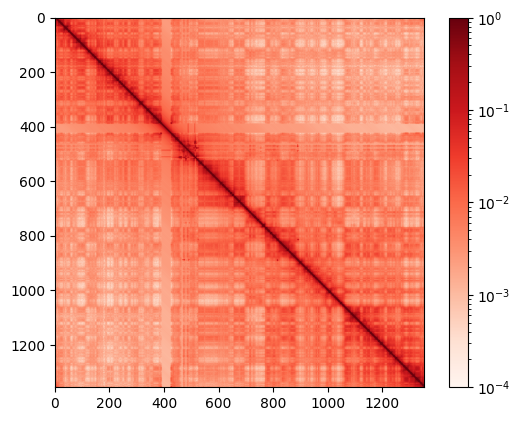

In [17]:
plt.imshow(hic_filled_norm, norm=mpl.colors.LogNorm(vmin = 0.0001, vmax=hic_norm.max()), cmap='Reds')
plt.colorbar()

Filling the NAs with neighbors copied

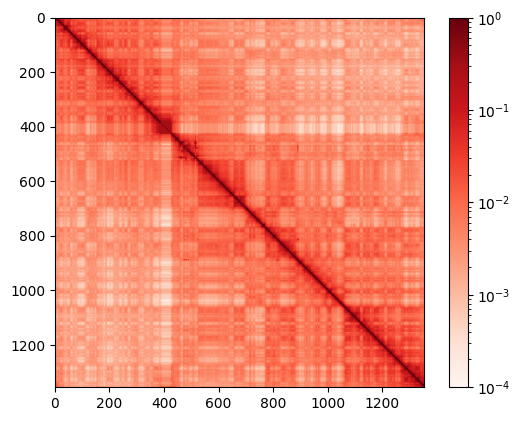

In [18]:
hic_filled = np.copy(hic_norm)

np.fill_diagonal(hic_filled, .0)

neighbor = 3
i = neighbor
for NA in range(390,422+neighbor):
    hic_filled[NA] = hic_norm[NA-i]
    i = i + 1

i = neighbor
for NA in range(462,468+neighbor):
    hic_filled[NA] = hic_norm[NA-i]
    i = i + 1

i = neighbor
for NA in range(476,482+neighbor):
    hic_filled[NA] = hic_norm[NA-i]
    i = i + 1

i = neighbor
for NA in range(490,490+neighbor):
    hic_filled[NA] = hic_norm[NA-i]
    i = i + 1

# centromer/centromer
# NA = 390
# hic_filled[390:422,390-neighbor:422] = hic_norm[NA:NA+1,NA:NA+1] #*0.3
neighbor=5
NA = 390
hic_filled[390-neighbor:422+neighbor,390-neighbor:422+neighbor] = hic_norm[NA:NA+1,NA-10:NA-9]

np.fill_diagonal(hic_filled,1.0)

hic_filled = np.tril(hic_filled,k=np.shape(hic_filled)[0])
hic_filled = hic_filled + np.transpose(hic_filled)

plt.imshow(hic_filled,norm=mpl.colors.LogNorm(vmin = 0.0001, vmax=hic_norm.max()),cmap='Reds')
plt.colorbar()

# save new file dense and plot
file_hic_filled_NA = 'chr10_100k_NA_neighbor.dense'
np.savetxt(file_hic_filled_NA, hic_filled)

plt.savefig(file_hic_filled_NA + '.pdf', bbox_inches='tight')


In [19]:
NA = 390
hic_norm[NA:NA+1,NA-10:NA-9]

array([[0.14495621]])